In [240]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

## Synthetic Data

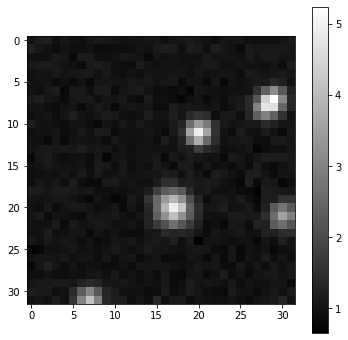

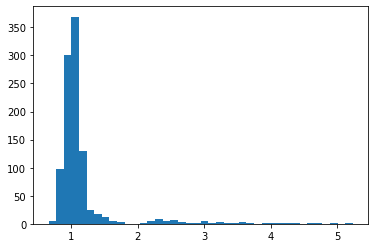

In [282]:
def make_image(shape, noise_mean = 1, noise_std = 1, num_obj = 1):

    rows = shape[0]
    cols = shape[1]

    # add noise
    num_pixels = sum(shape)
    noise_layer = np.random.normal(loc = noise_mean, scale = noise_std, size = shape)
    image = noise_layer
    

    for i in range(num_obj):
        sigma = np.random.uniform(0.4,1.5)
        amp = np.random.uniform(1,5)
        x0, y0 = np.random.randint(0, rows), np.random.randint(0, cols)
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        gaussian = amp*np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))


        image += gaussian

    errors = np.sqrt(image)


    return image, errors


# testing

shape = (32,32)
noise_mean = 1
noise_std = 0.1
num_obj = np.random.randint(1,20)

image, errors = make_image(shape, noise_mean, noise_std, num_obj)
plt.figure(figsize = (6,6))
plt.imshow(image, cmap = 'gray')
plt.colorbar()
#print(image)
#print(errors)


image_flatten = np.array(image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (6,4))
histogram = plt.hist(image_flatten, density = False, bins = 40)

In [ ]:
# generate batches of data


## BVAE class

In [293]:
class BVAE(keras.Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def bvae_compile(self, optimizer):
        self.compile()
        self.optimizer = optimizer 

    @tf.function
    def train_step(self, data):

        x, errs, logbeta = data

        with tf.GradientTape as tape:
            # encode batch to latent vectors
            z_mean, z_log_var, z = self.encoder((x, logbeta))
            # decode batch from z 
            reconstruction = self.decoder(z, logbeta)

            """Weighted MSE"""
            difference = tf.math.subtract(x, reconstruction)
            reconstruction_loss = K.mean(K.square(tf.multiply(difference, tf.math.reciprocal(errs))))

            """KL Loss"""
            # calculate kl loss across latent variables of each image in batch
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # sum loss over latent dimensions, calculate mean of batch
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            # calculate total loss, include B regularizzer
            total_loss = reconstruction_loss + tf.exp(logbeta) * kl_loss

        # grad loss wrt weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # apply gradients to weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # update state of trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    
    def predict_MLE(self, data):
        x, errs, logbeta = data
        z_mean, z_log_var, z = self.encoder((x, logbeta))
        reconstruction = self.decoder(z_mean, logbeta)

        return reconstruction
  

In [296]:
#sampling
latent_dim = 128
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=0.1)
    return z_mean + K.exp(0.5*z_log_var) * epsilon


# build and compile bvae
def build_and_compile_bvae(input_shape,
                           encoder_conv_layers = [64,64],
                           encoder_dense_layers = [32],
                           decoder_dense_layers = [32],
                           decoder_conv_layers = [64, 64],
                           latent_dim = 128,
                           dropout = 0,
                           optimizer=keras.optimizers.Adam(),
                           verbose = True):
                          

    # encoder
    inputs = tf.keras.Input(shape = input_shape, name = 'inputs')
    logbeta = tf.keras.Input(shape = (1,), name = 'logbeta_inputs')
    layer = inputs

    # enc_conv layers
    for layer_size in encoder_conv_layers:
        layer = layers.Conv2D(layer_size, (3,3), padding = 'same')(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        layer = keras.layers.BatchNormalization()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # flatten
    layer = keras.layers.Flatten()(layer)
    # concat
    layer = keras.layers.Concatenate()([layer, logbeta])

    # enc_dense layers
    for size in encoder_dense_layers:
        layer = keras.layers.Dense(size)(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # encode to z 
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(layer)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(layer)

    layer = tf.stack([z_mean,z_log_var])
    z = tfpl.DistributionLambda(make_distribution_fn = lambda t: tfd.MultivariateNormalDiag(t[0],tf.exp(t[1]/2)),
                                    name="encoder_gauss_distribution")(layer)
                                   
    encoder = keras.Model([inputs,logbeta], [z_mean, z_log_var, z], name= 'encoder')
    if verbose:
        encoder.summary()

    # Decoder
    latent_inputs_gauss = keras.Input(shape=(latent_dim,), name='z_sampling')
    logbeta_decoder = keras.Input(shape=(1,), name='logbeta_decoder')
    layer = keras.layers.Concatenate()([latent_inputs_gauss,logbeta_decoder])

    # dec_dense layers
    for size in decoder_dense_layers:
        layer = keras.layers.Dense(size)(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # intermediate layer 
    layer = keras.layers.Dense(input_shape[0]*input_shape[1]*decoder_conv_layers[0])(layer)
    # reshape
    layer = keras.layers.Reshape(target_shape = (input_shape[0], input_shape[1], decoder_conv_layers[0]))(layer)

    # dec_conv layers
    for layer_size in decoder_conv_layers:
        layer = layers.Conv2D(layer_size, (3,3), padding = 'same')(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        layer = keras.layers.BatchNormalization()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # final layer 
    decoded = layers.Conv2D(1, (3,3), padding = 'same')(layer)

    decoder = keras.Model([latent_inputs_gauss, logbeta_decoder], decoded, name = 'decoder')
    
    if verbose:
        decoder.summary()

    outputs = decoder([encoder([inputs,logbeta])[2],logbeta])
    vae = BVAE(encoder, decoder)
    vae.bvae_compile(optimizer = optimizer)

    return vae, encoder, decoder

shape = (32,32,1)
vae, encoder, decoder = build_and_compile_bvae(input_shape = shape)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_74 (Conv2D)             (None, 32, 32, 64)   640         ['inputs[0][0]']                 
                                                                                                  
 leaky_re_lu_110 (LeakyReLU)    (None, 32, 32, 64)   0           ['conv2d_74[0][0]']              
                                                                                                  
 batch_normalization_65 (BatchN  (None, 32, 32, 64)  256         ['leaky_re_lu_110[0][0]']        
 ormalization)                                                                              